In [55]:
import skimage
import skimage.io as sio
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd

from skimage.filters import gaussian
from skimage.filters import sobel, prewitt, scharr
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label
from skimage.measure import regionprops


### Using OpenCv Canny Edge Detector

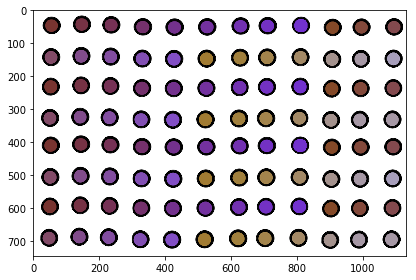

In [64]:
img = cv.imread('../doc/wellplate.png',1)
edges = cv.Canny(img,2,4,L2gradient = True)
sio.imsave('edges.png',edges)
image = sio.imshow(img)

In [6]:
image

(Text(0.5, 1.0, 'Edge Image'), [], [])

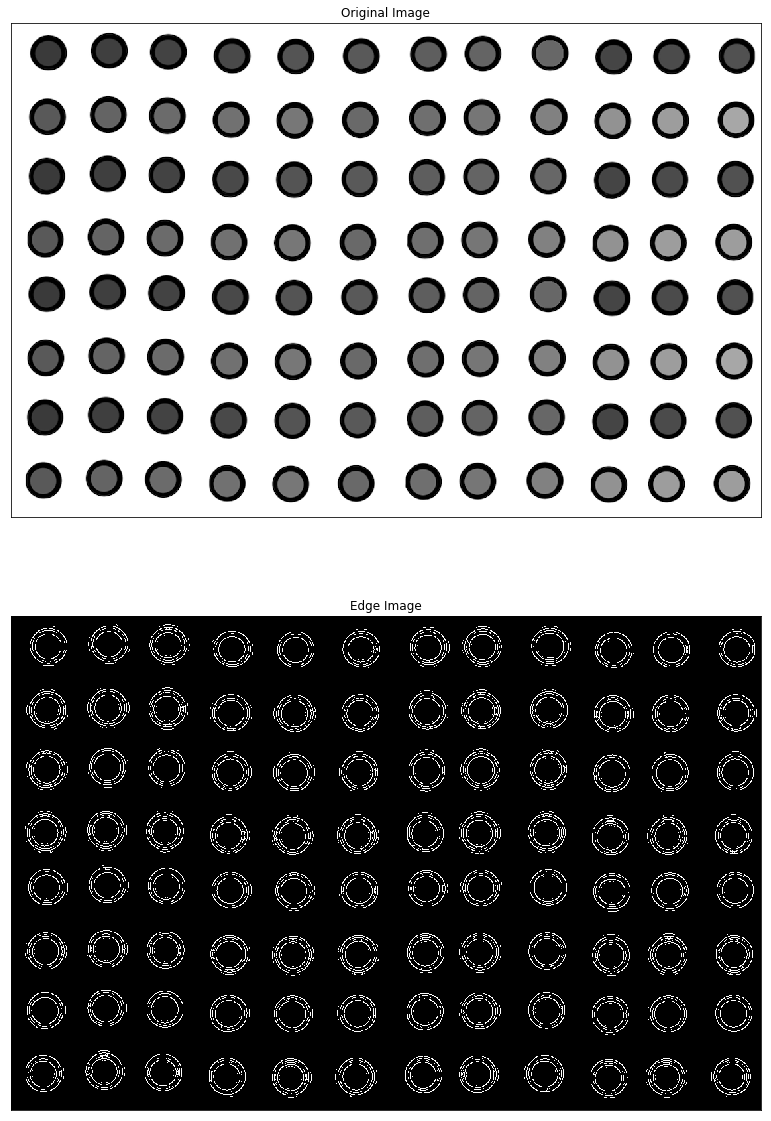

In [7]:
fig,ax = plt.subplots(2,1,figsize=(20,20))
ax[0].imshow(img,cmap = 'gray')
ax[0].set_title('Original Image'), ax[0].set_xticks([]), ax[0].set_yticks([])
ax[1].imshow(edges,cmap = 'gray')
ax[1].set_title('Edge Image'), ax[1].set_xticks([]), ax[1].set_yticks([])


 ### Adding a Gaussian filter, an edge detector, and a threshold all together to make our own mini Canny edge detector:

In [ ]:
# image = cv.imread(image_name,colorscale)
#     gaus = gaussian(image, sigma=2)
#     sob = sobel(gaussian(image, sigma=2))
#     edges = sobel(gaussian(image, sigma=2)) > 0.03
# #     fig, axes = plt.subplots(2,2,figsize=(19, 10))
# #     axes[0,0].imshow(image, cmap='gray')
# #     axes[0,1].imshow(gaussian, cmap='gray')
# #     axes[1,0].imshow(sobel, cmap='gray')
# #     axes[1,1].imshow(edges, cmap='gray')

In [65]:
def edge_detection(image_name, colorscale):
    '''Detects the edges in the image
    Args:
        image_name(string): File name of the image to be processed
        colorscale(int): 0 for grayscale and 1 for original color
        
    Returns:
        edges(Numpy array): Image with detected egdes
    '''
    image = cv.imread(image_name,colorscale)
    gaus = gaussian(image, sigma=2)
    sob = sobel(gaussian(image, sigma=2))
    edges = sobel(gaussian(image, sigma=2)) > 0.03
    return edges

In [66]:
edge_image = edge_detection('../doc/wellplate.png',0)

In [72]:
type(edge_image)

numpy.ndarray

### Separating the wellplates from the backgroung

Text(0.5, 1.0, 'Canny Edge Detector')

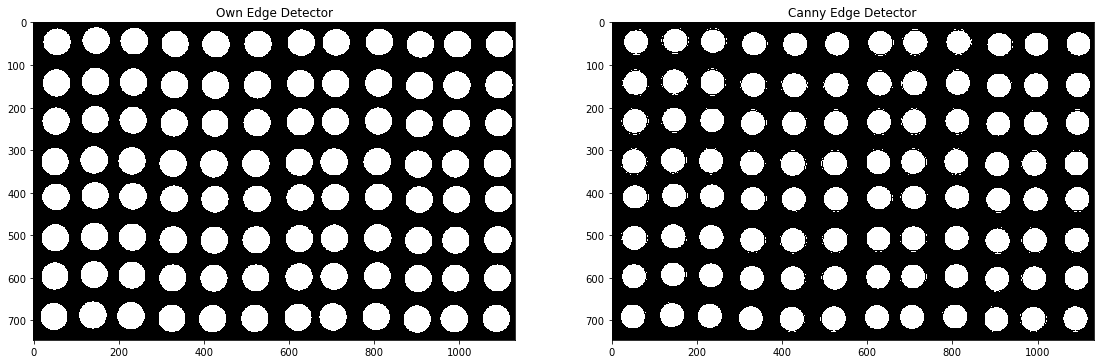

In [67]:
from scipy.ndimage.morphology import binary_fill_holes

filled_wells = binary_fill_holes(thre)
filled_wells_canny = binary_fill_holes(edges)
figure, ax = plt.subplots(1,2,figsize=(19, 10))
ax[0].imshow(filled_wells, cmap = 'gray')
ax[0].set_title('Own Edge Detector')
ax[1].imshow(filled_wells_canny, cmap = 'gray')
ax[1].set_title('Canny Edge Detector')


### The above images show that our own detector is better than the canny edge detector

#### Function to fill the wells and label the filled wells

In [68]:
def fill_label_holes(edge_image):
    '''
    This function takes the image with detected egdes as the
    input and returns an image with filled and labeled wellplates.
    
    Args:
        edge_image(Numpy array): Image with detected egdes
        
    Returns:
        labeled_wells(Numpy array): Image with filled and labeled wells
        which can be used to determine the properties of the well.
    '''
    filled_wells = binary_fill_holes(edge_image)
    labeled_wells = label(filled_wells)
    return labeled_wells
#     figure, ax = plt.subplots(1,2,figsize=(19, 10))
#     ax[0].imshow(filled_wells, cmap = 'gray')
#     ax[0].set_title('Own Edge Detector')
#     ax[1].imshow(filled_wells_canny, cmap = 'gray')
#     ax[1].set_title('Canny Edge Detector')

In [73]:
labeled_wells = fill_label_holes(edge_image)

In [74]:
type(labeled_wells)

numpy.ndarray

### Labeling the well plates
##### Labeling assigns all the pixels with the same intensities with the same value.

In [70]:
def label_wells(filled_wells):
    lab_wells = label(filled_wells)
#     fig, ax = plt.subplots()
#     ax.imshow(lab_wells*10, vmin=0)
#     ax.axis('off')

#### We can use our labelled image as the input to the function to determine the image properties

In [71]:
def image_properties(labeled_wells, image_name, colorscale):
    '''
    This function takes the image with filled and labeled holes and original
    image as the input and returns the properties and returns the properties
    of all the wells in a single frame.
    
    Args:
        labeled_wells(Numpy Array): Image with filled and labeled wells
        which can be used to determine the properties of the well.
        image_name(string): File name of the image to be processed
        colorscale(int): 0 for grayscale and 1 for original color
        
    Returns:
        regprops(dataframe): A dataframe containing the properties of
        all the wells in a single frame.
    '''
    image = cv.imread(image_name,colorscale)
    props = regionprops(labeled_wells, intensity_image=image)
    x = np.zeros(len(props))
    y = np.zeros(len(props))
    area = np.zeros(len(props))
    perim = np.zeros(len(props))
    intensity = np.zeros(len(props))

    counter = 0
    for prop in props:
        x[counter] = prop.centroid[0]
        y[counter] = prop.centroid[1]
        area[counter] = prop.area
        perim[counter] = prop.perimeter
        intensity[counter] = prop.mean_intensity
    
        counter += 1

    regprops = pd.DataFrame({'X': x, 'Y': y, 'Area': area,
                            'Perim': perim, 'Mean Intensity': intensity})
    return regprops

In [75]:
regprops = image_properties(labeled_wells,'../doc/wellplate.png',0)
type(regprops)

pandas.core.frame.DataFrame

#### The mean intensity of each well can be used to determine temperature at each well

In [31]:
regionprops

,X,Y,Area,Perim,Mean Intensity
0,42.778657,147.988600,3158.0,208.066017,90.734326
1,44.577982,237.182537,3161.0,207.237590,92.628282
2,46.172337,56.254054,3145.0,208.066017,89.035930
3,47.164345,711.720076,3158.0,207.237590,104.827106
4,46.353090,813.170523,3155.0,207.823376,111.813946
5,47.857279,629.665817,3139.0,205.823376,102.533928
6,50.504453,333.360687,3144.0,206.651804,95.056298
7,50.638291,528.205380,3160.0,207.237590,100.629747
8,50.654042,1095.351369,3142.0,206.166522,97.638129
9,51.509362,429.428118,3151.0,205.823376,98.129483
